In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
data_dir = '/om2/user/rogerjin/data/SNARESeq/original/adult_brain_cortex'
cdna_path = f'{data_dir}/GSE126074_AdBrainCortex_SNAREseq_cDNA.counts.mtx'
cdna_genes_path = f'{data_dir}/GSE126074_AdBrainCortex_SNAREseq_cDNA.genes.tsv'
atac_path = f'{data_dir}/GSE126074_AdBrainCortex_SNAREseq_chromatin.counts.mtx'
cdna_barcodes_path = f'{data_dir}/GSE126074_AdBrainCortex_SNAREseq_cDNA.barcodes.tsv'

In [3]:
# import sys

# num_bytes = sys.getsizeof(rna)

# def sizeof_fmt(num, suffix="B"):
#     # https://stackoverflow.com/questions/1094841/get-human-readable-version-of-file-size
#     for unit in ["", "Ki", "Mi", "Gi", "Ti", "Pi", "Ei", "Zi"]:
#         if abs(num) < 1024.0:
#             return f"{num:3.1f}{unit}{suffix}"
#         num /= 1024.0
#     return f"{num:.1f}Yi{suffix}"

# sizeof_fmt(num_bytes)

In [4]:
import scanpy as sc

sc.set_figure_params(dpi=300)
sc._settings.ScanpyConfig.n_jobs = 4

In [5]:
import pandas as pd

cell_ids = pd.read_csv(cdna_barcodes_path, header=None)
cell_ids.index = cell_ids.index.map(str)
cell_ids.columns = ['cell_id']
cell_ids

cell_id
0      09A_CAGCCCCGCCTT
1      09A_CGCCTACCATGA
2      09A_GATGCGCGGCTA
3      09A_GGTCCGAGTCCT
4      09A_TCTCCCGGCACC
...                 ...
10304  09L_TACTAGTTCAAG
10305  09L_ATGACGGGCCCC
10306  09L_GAAACACCTCAT
10307  09L_AACGGTTTATCC
10308  09L_GACTGATACAGT

[10309 rows x 1 columns]

In [6]:
labels_path = 'snareseq_ad_annot_labeled.csv'
labels = pd.read_csv(labels_path).drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)
cell_types = labels[['cell_id', 'cell_type']]

In [7]:
rna = sc.read_mtx(cdna_path).T
rna.obs = rna.obs.merge(cell_ids, left_index=True, right_index=True)

In [8]:
import pandas as pd
rna_genes = pd.read_csv(cdna_genes_path, header=None)

In [9]:
mito_genes = pd.read_csv('mitochondrial_genes.csv')
mito_genes

GeneID  Symbol                                        Description  \
0      66445    Cyc1                                     cytochrome c-1   
1      18597   Pdha1                  pyruvate dehydrogenase E1 alpha 1   
2      66043   Atp5d  "ATP synthase, H+ transporting, mitochondrial ...   
3      74316   Isca2  iron-sulfur cluster assembly 2 homolog (S. cer...   
4      22273  Uqcrc1    ubiquinol-cytochrome c reductase core protein 1   
...      ...     ...                                                ...   
1153   78617   Cstad  "CSA-conditional, T cell activation-dependent ...   
1154   54447   Asah2                 N-acylsphingosine amidohydrolase 2   
1155   29876   Clic4   chloride intracellular channel 4 (mitochondrial)   
1156   67474  Snap29                 synaptosomal-associated protein 29   
1157   73681  Trmt11                          tRNA methyltransferase 11   

                                               Synonyms  Maestro score  FDR  \
0                       2610002H19Rik, AA408921, Q9D0M3             44   0%   
1                                        Pdha-1, P35486             42   0%   
2     0610008F14Rik, 1500000I11Rik, AA960090, AI8765...             42   0%   
3           0710001C05Rik, 5730594E03Rik, Hbld1, Q9DCB8             42   0%   
4                                 1110032G10Rik, Q9CZ13             42   0%   
...                                                 ...            ...  ...   
1153                              9530039B02Rik, Q9D245             -8  84%   
1154                                   AI585898, Q9JHE3             -8  87%   
1155               D0Jmb3, TU-74, mc3s5, mtCLIC, Q9QYB1             -9  88%   
1156  1300018G05Rik, AI891940, AU020222, BB131856, G...            -11  88%   
1157     2410075D05Rik, 3110045I18Rik, AW213713, Q9CWH5            -11  88%   

                                               Evidence  \
0     "literature, APEX_IMS, APEX_matrix, targetP si...   
1     "literature, APEX_matrix, targetP signal+, yea...   
2     "literature, APEX_matrix, targetP signal, yeas...   
3     "APEX_matrix, targetP signal+, yeast mito homo...   
4     "literature, APEX_matrix, targetP signal+, yea...   
...                                                 ...   
1153                                         literature   
1154                                         literature   
1155                                         literature   
1156                                           APEX_IMS   
1157                                        APEX_matrix   

                       Tissues  
0                       all 14  
1                       all 14  
2                       all 14  
3                       all 14  
4                       all 14  
...                        ...  
1153                      none  
1154  smallintestine, placenta  
1155         stomach, placenta  
1156                      none  
1157                      none  

[1158 rows x 8 columns]

In [10]:
# is_mito = rna_genes.apply(lambda gene: gene i
mito_gene_set = set(mito_genes.Symbol)
is_mito = rna_genes[0].apply(lambda gene: gene in mito_gene_set)

# compute % mitochondrial reads
rna.var_names = rna_genes[0]
rna.var['mt'] = rna.var_names.isin(mito_gene_set)

In [11]:
rna.var['mt']

0610005C13Rik    False
0610007P14Rik    False
0610009B22Rik    False
0610009E02Rik    False
0610009L18Rik    False
                 ...  
Vmn2r-ps83       False
Vmn2r50          False
Vpreb2           False
n-R5s32          False
n-R5s50          False
Name: mt, Length: 33160, dtype: bool

In [12]:
sc.pp.calculate_qc_metrics(rna, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

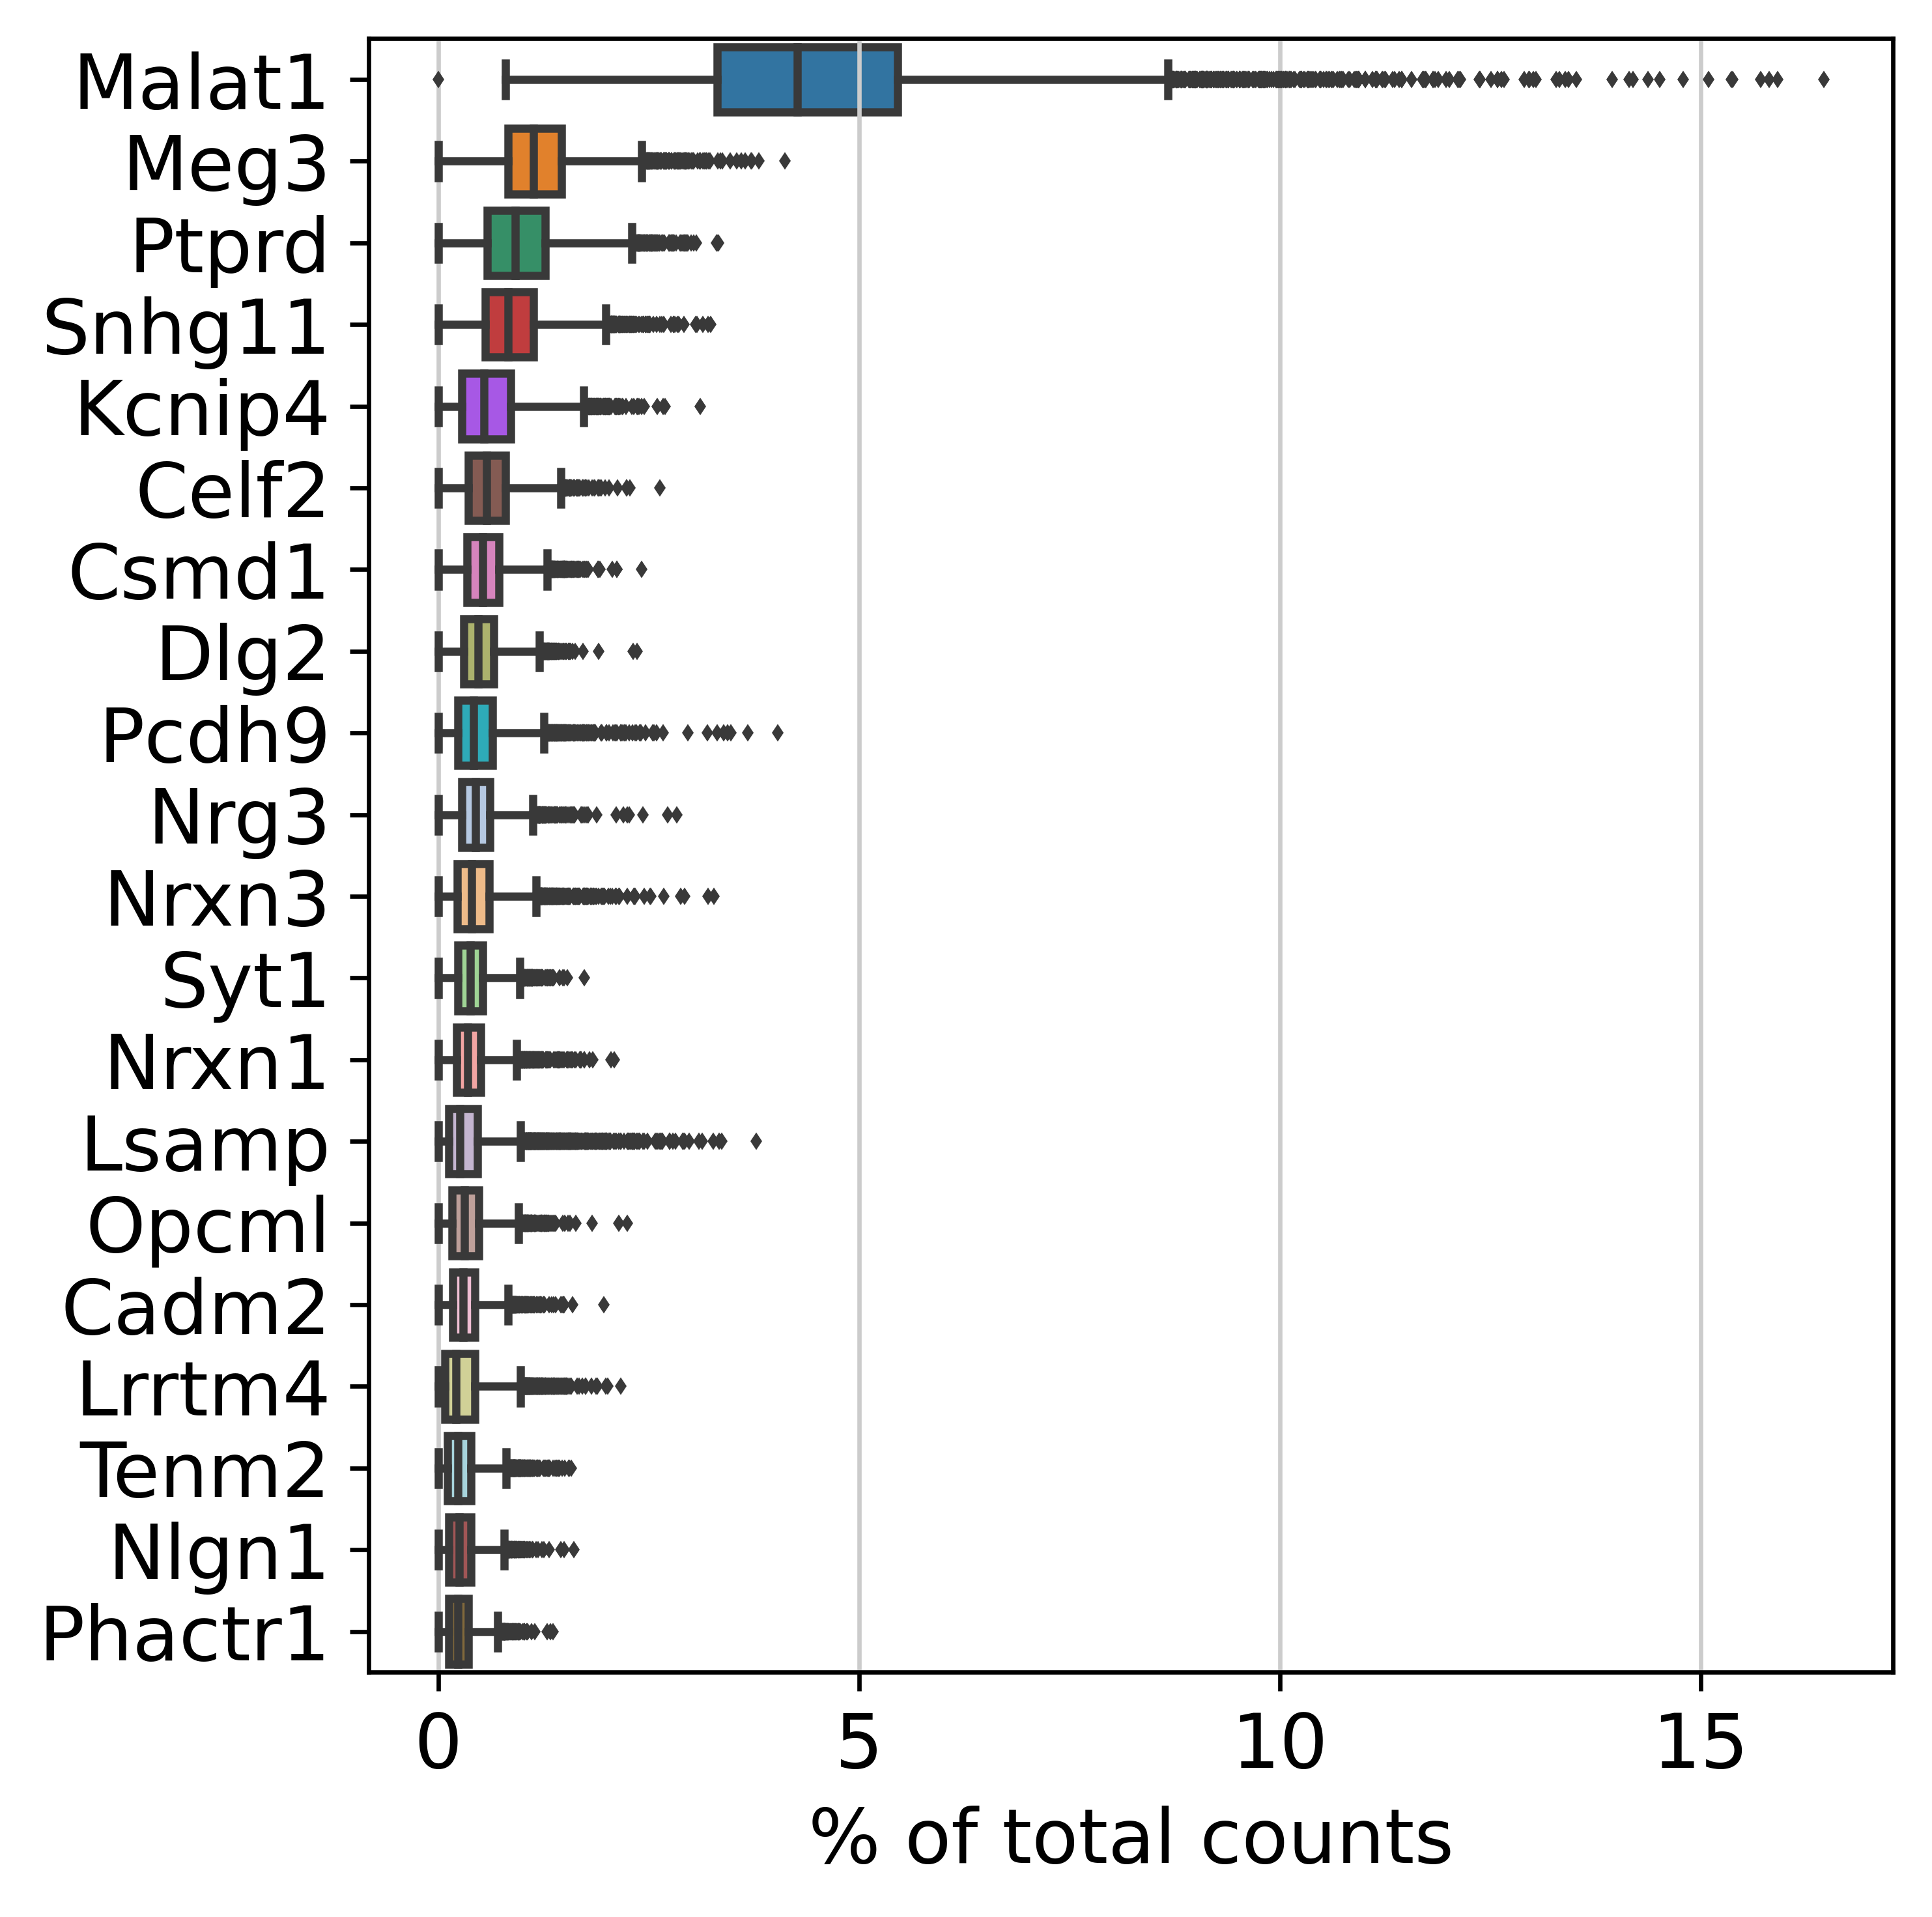

In [13]:
sc.pl.highest_expr_genes(rna, n_top=20)

In [14]:
sc.pp.filter_cells(rna, min_genes=200)
sc.pp.filter_genes(rna, min_cells=3)

In [ ]:
sc.pl.violin(rna, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [ ]:
sc.pl.scatter(rna, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(rna, x='total_counts', y='n_genes_by_counts')

In [ ]:
rna = rna[rna.obs.n_genes_by_counts < 2500, :]
rna = rna[rna.obs.pct_counts_mt < 5, :]

In [ ]:
rna.obs['idx'] = rna.obs.index
merged = rna.obs.merge(cell_types, on='cell_id')
rna = rna[merged.idx, :]
rna.obs['cell_type'] = merged.cell_type.values

In [ ]:
sc.pp.normalize_total(rna, target_sum=1e4)
sc.pp.log1p(rna)
sc.pp.highly_variable_genes(rna, min_mean=0.0125, max_mean=3, min_disp=0.5)

In [ ]:
sc.pl.highly_variable_genes(rna)

In [ ]:
sc.pp.regress_out(rna, ['total_counts', 'pct_counts_mt'])

In [ ]:
sc.pp.scale(rna, max_value=10)

In [ ]:
sc.tl.pca(rna, svd_solver='arpack')

In [ ]:
sc.pl.pca(rna, color='cell_type')

In [ ]:
sc.pl.pca_variance_ratio(rna, log=True)

In [ ]:
sc.pp.neighbors(rna, n_neighbors=10, n_pcs=40)

In [ ]:
sc.tl.leiden(rna)
sc.tl.paga(rna)
sc.pl.paga(rna, plot=False)
sc.tl.umap(rna, init_pos='paga')

In [ ]:
sc.pl.umap(rna, color='cell_type')

In [ ]:
rna.write('snareseq_rna.h5ad')

In [ ]:
import anndata as ad

rna = ad.read('snareseq_rna.h5ad')
rna

# ATAC

In [ ]:
atac = sc.read_mtx(atac_path).T
atac.shape

In [30]:
import episcanpy.api as epi
from ganoli_plot import plot_umap

atac.obs = atac.obs.merge(cell_ids, left_index=True, right_index=True)

In [31]:
def simplify_cell_type(cell_type):
    if cell_type.lower().startswith('ex'):
        return 'Ex'
    elif cell_type.lower().startswith('in'):
        return 'In'
    return cell_type
cell_types['cell_type_simple'] = cell_types.cell_type.apply(simplify_cell_type)
cell_types

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


cell_id         cell_type cell_type_simple
0     09A_TCTCCCGGCACC       Ex-L5-Parm1               Ex
1     09A_ACCAAATCTTGT  Ex-L4/5-Il1rapl2               Ex
2     09A_ACGGACTACGCT    Ex-L4/5-Thsd7a               Ex
3     09A_TAAGGAAGAGGA        Ex-L6-Tle4               Ex
4     09A_CATGTGTCACCC    Ex-L4/5-Thsd7a               Ex
...                ...               ...              ...
9192  09L_TACTAGTTCAAG               Mic              Mic
9193  09L_ATGACGGGCCCC               Mic              Mic
9194  09L_GAAACACCTCAT               Mic              Mic
9195  09L_AACGGTTTATCC          In-Pvalb               In
9196  09L_GACTGATACAGT               Mic              Mic

[9197 rows x 3 columns]

In [32]:
atac.obs['idx'] = rna.obs.index
merged = atac.obs.merge(cell_types, on='cell_id')
atac = atac[merged.idx, :]
atac.obs['cell_type'] = merged.cell_type.values
atac.obs['cell_type_simple'] = merged.cell_type_simple.values

Trying to set attribute `.obs` of view, copying.


In [42]:
# remove any potential empty features or barcodes
epi.pp.filter_cells(atac, min_features=1)
epi.pp.filter_features(atac, min_cells=1)

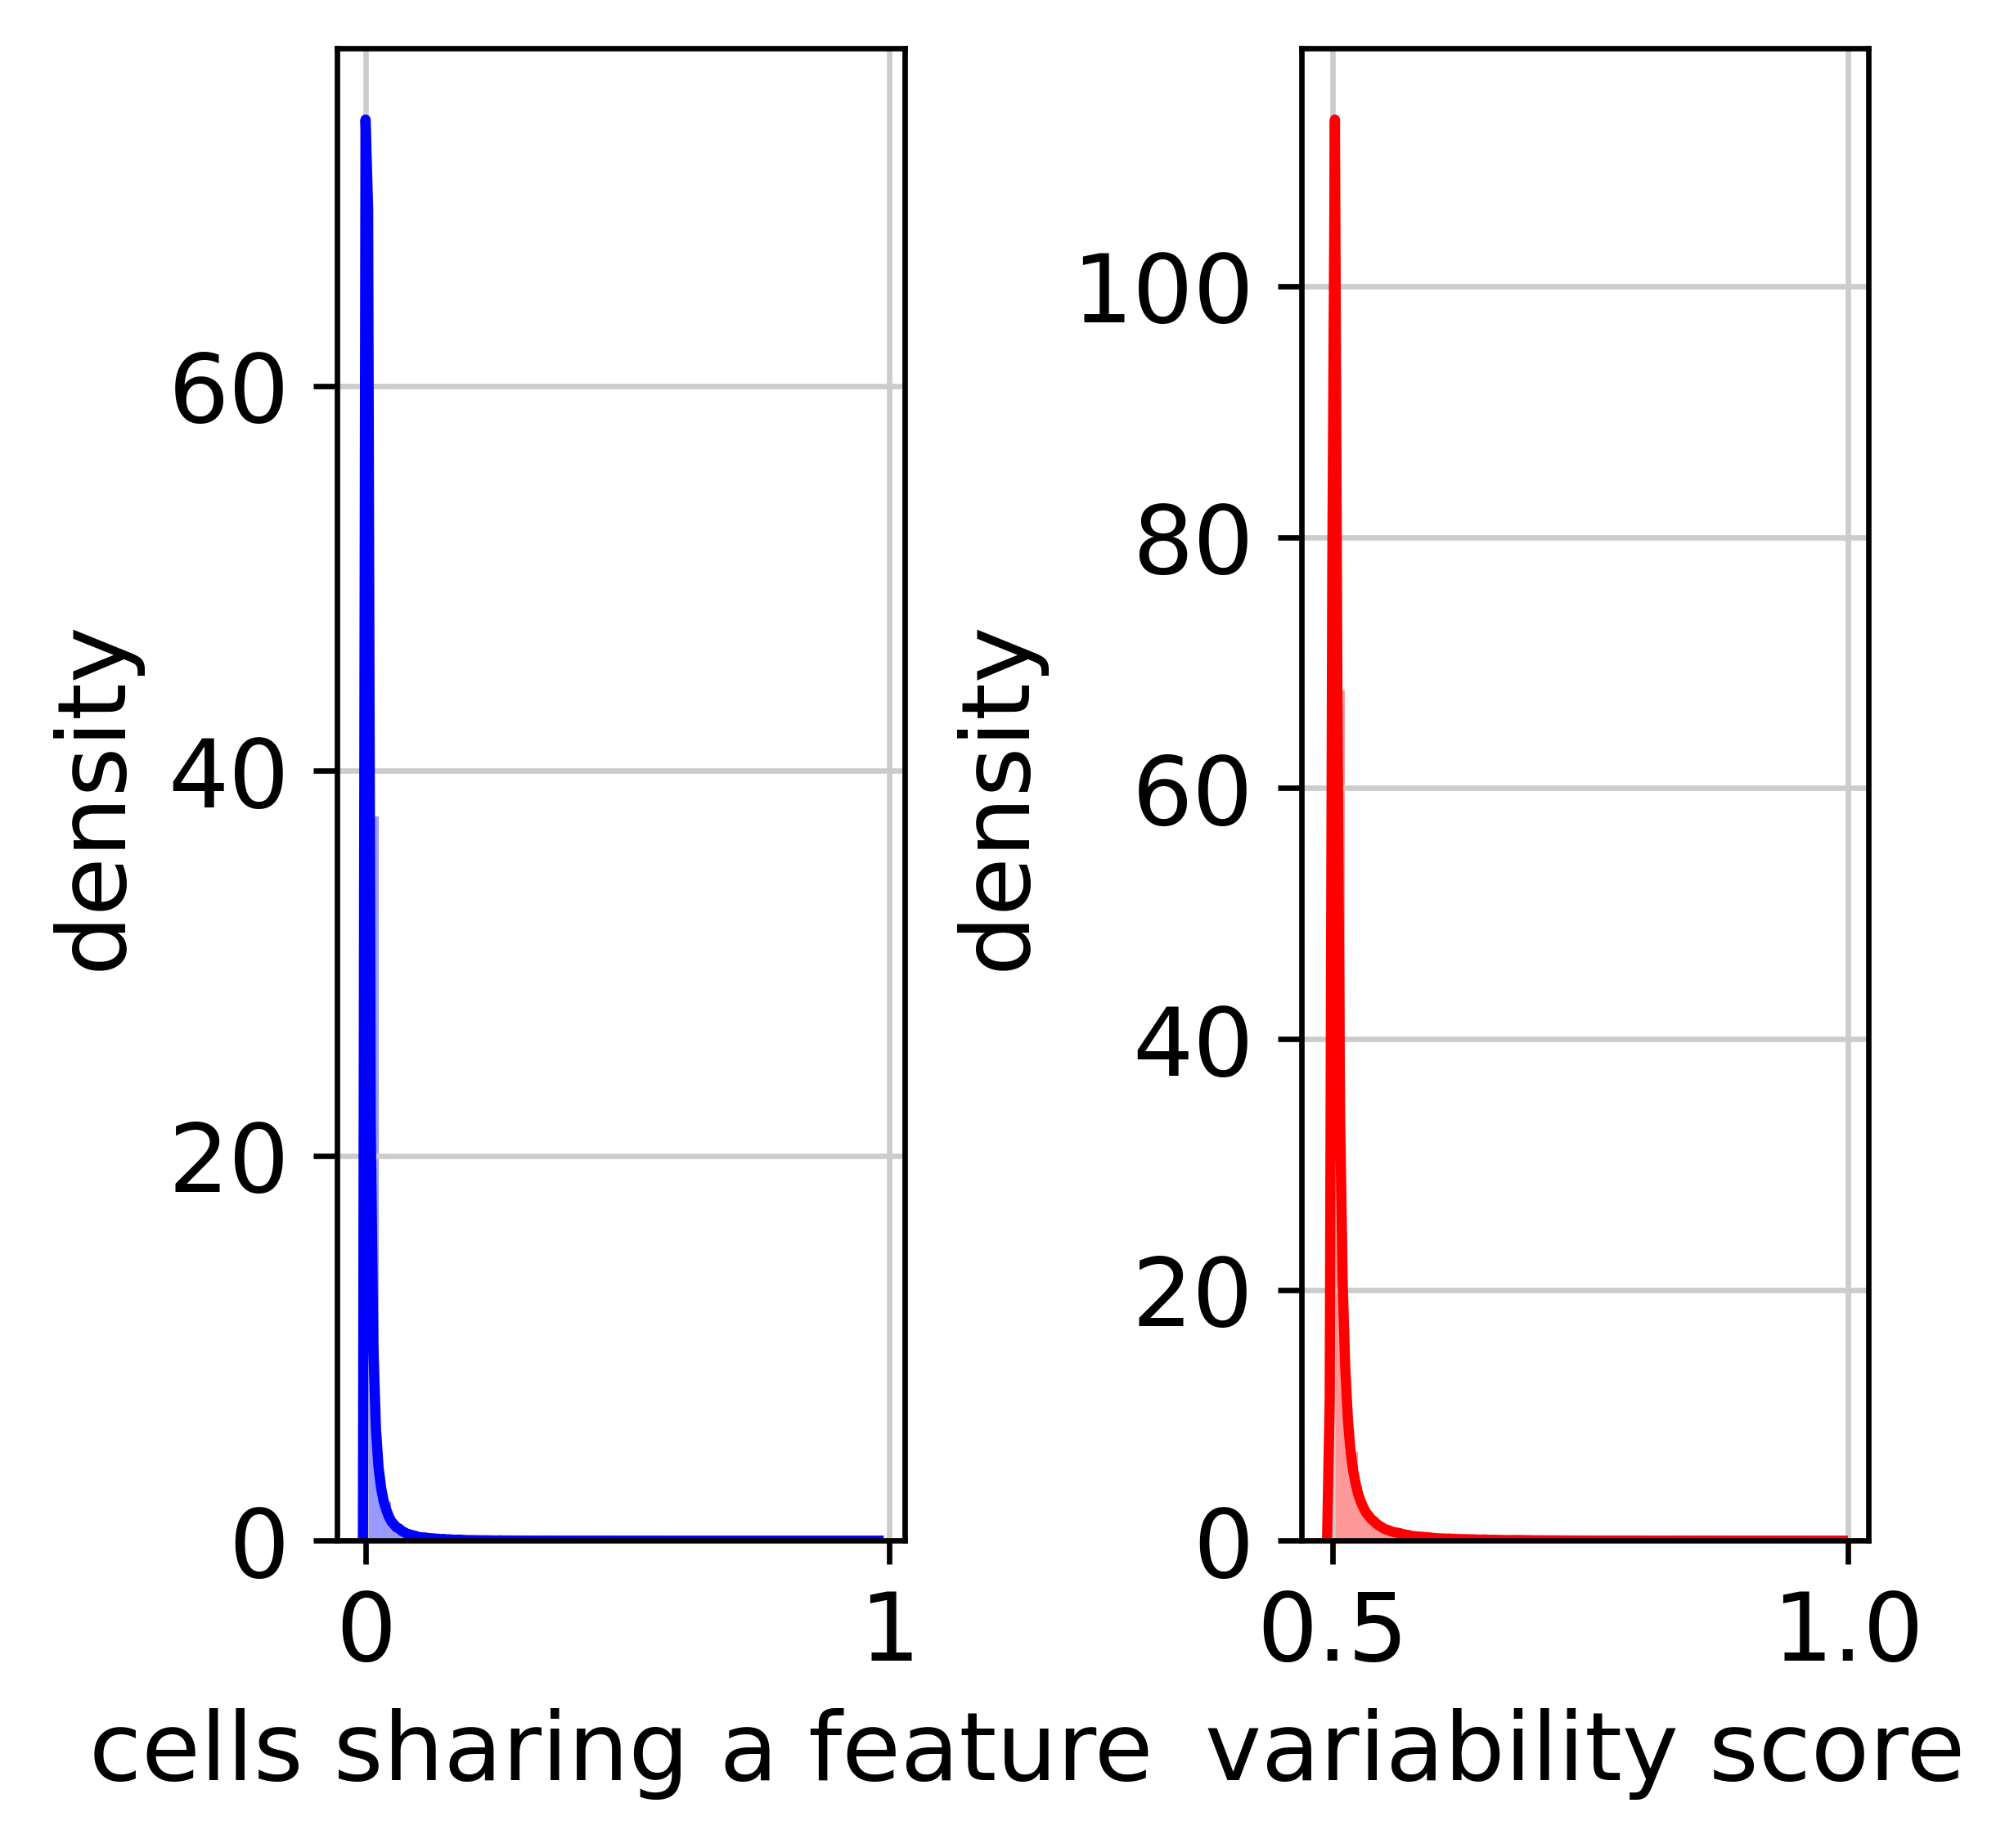

In [44]:
epi.pp.cal_var(atac)
atac = epi.pp.select_var_feature(atac,
                                  nb_features=120000,
                                  show=False,
                                  copy=True)

In [48]:
epi.pp.filter_cells(atac, min_features=2000)
epi.pp.filter_cells(atac, max_features=25000)

Trying to set attribute `.obs` of view, copying.


In [51]:
epi.pp.lazy(atac)

In [54]:
atac

AnnData object with n_obs × n_vars = 4503 × 120001
    obs: 'cell_id', 'idx', 'cell_type', 'cell_type_simple', 'nb_features'
    var: 'n_cells', 'prop_shared_cells', 'variability_score'
    uns: 'pca', 'neighbors', 'tsne', 'umap', 'cell_type_simple_colors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'binary'
    obsp: 'distances', 'connectivities'

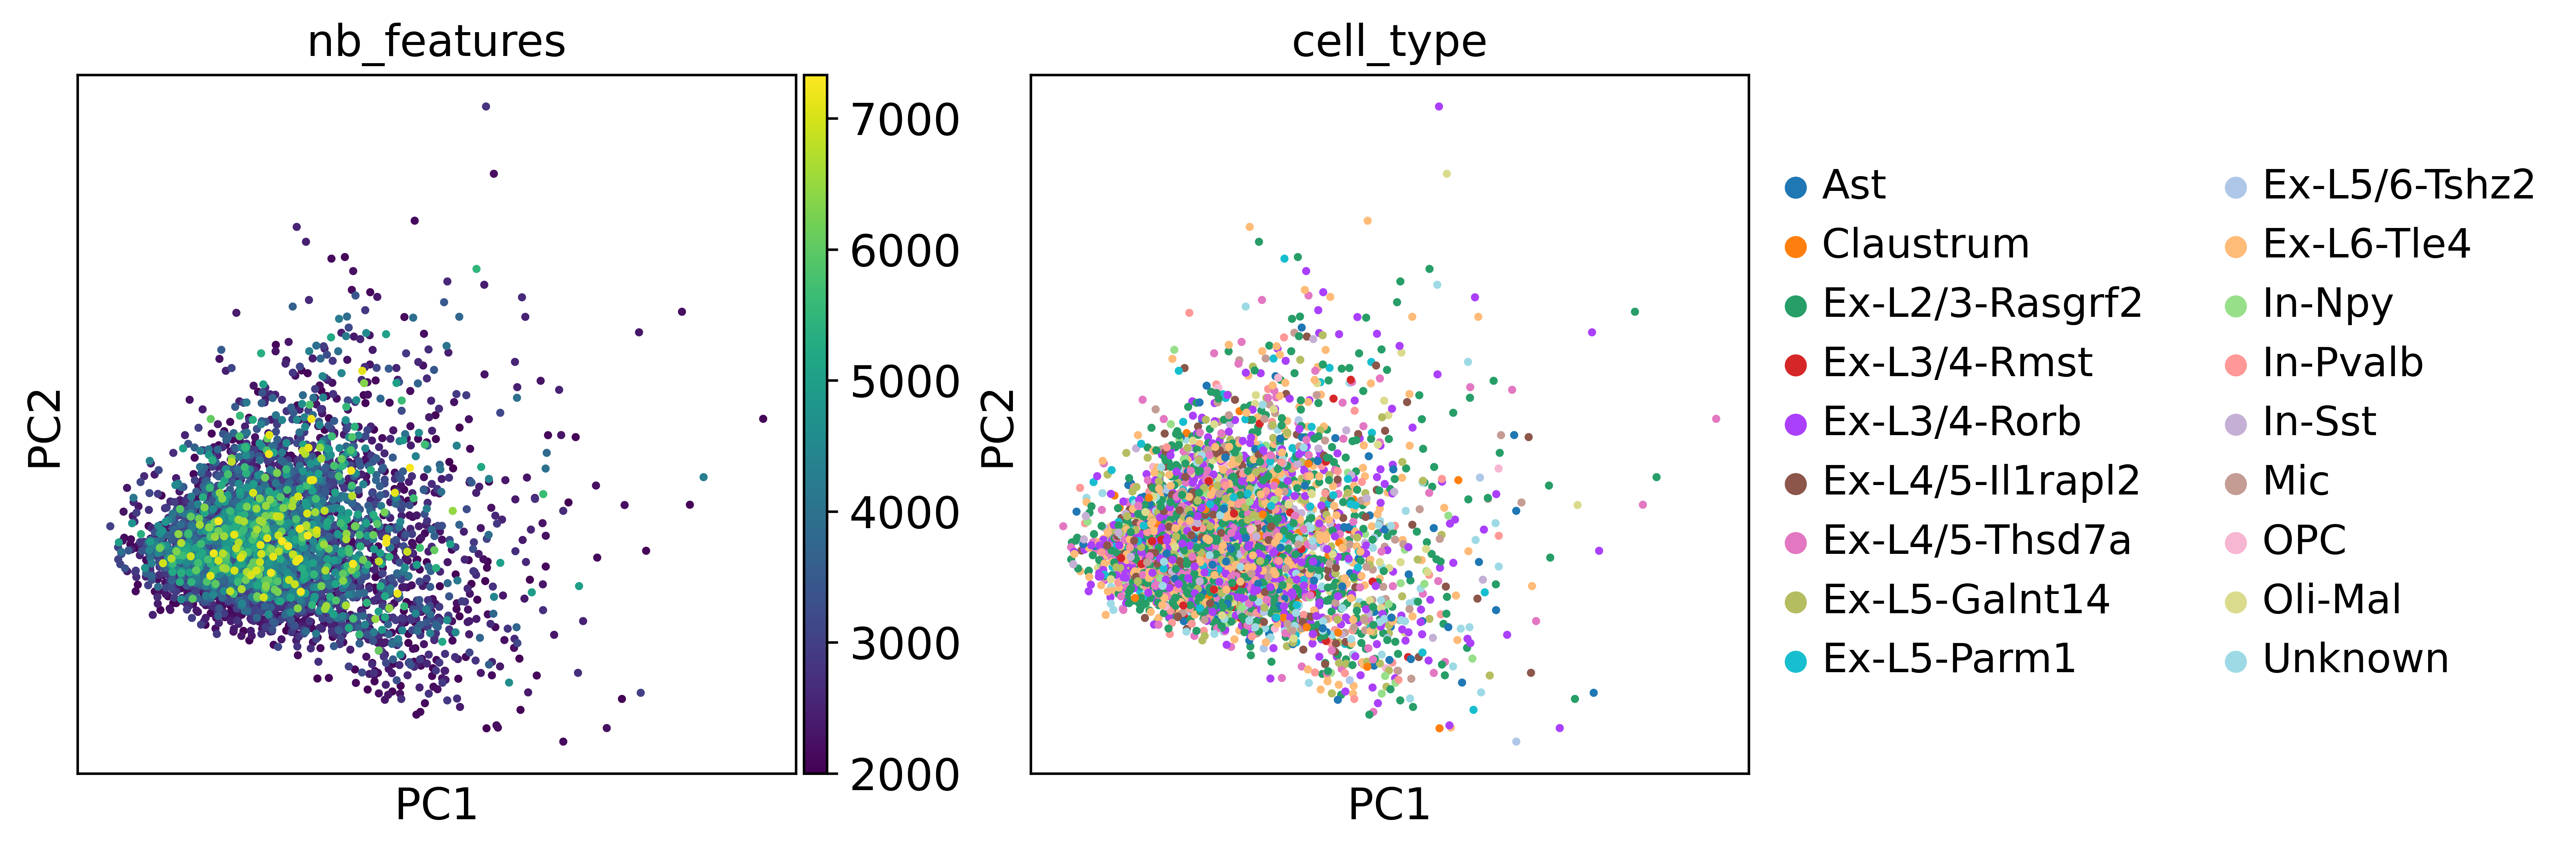

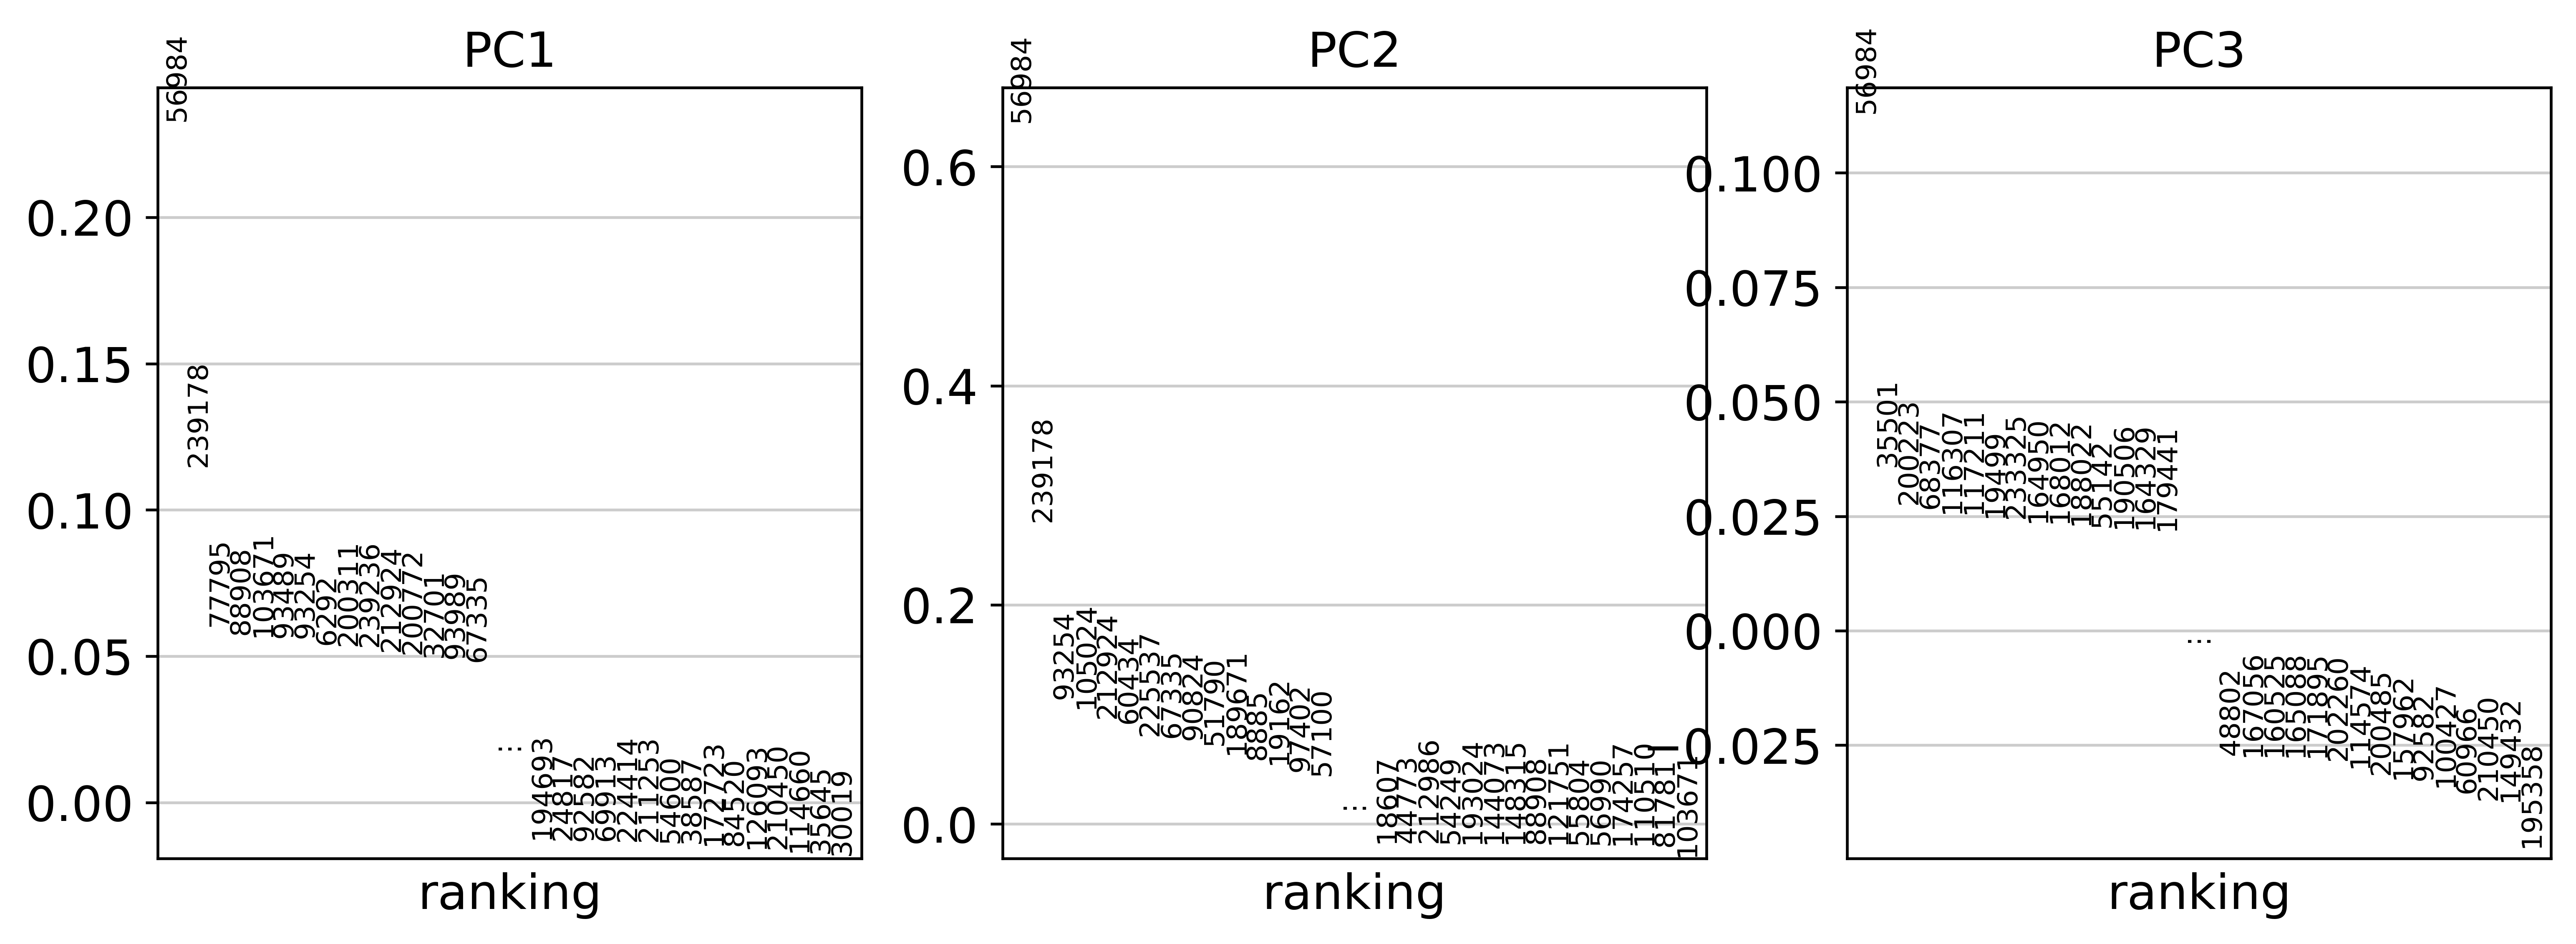

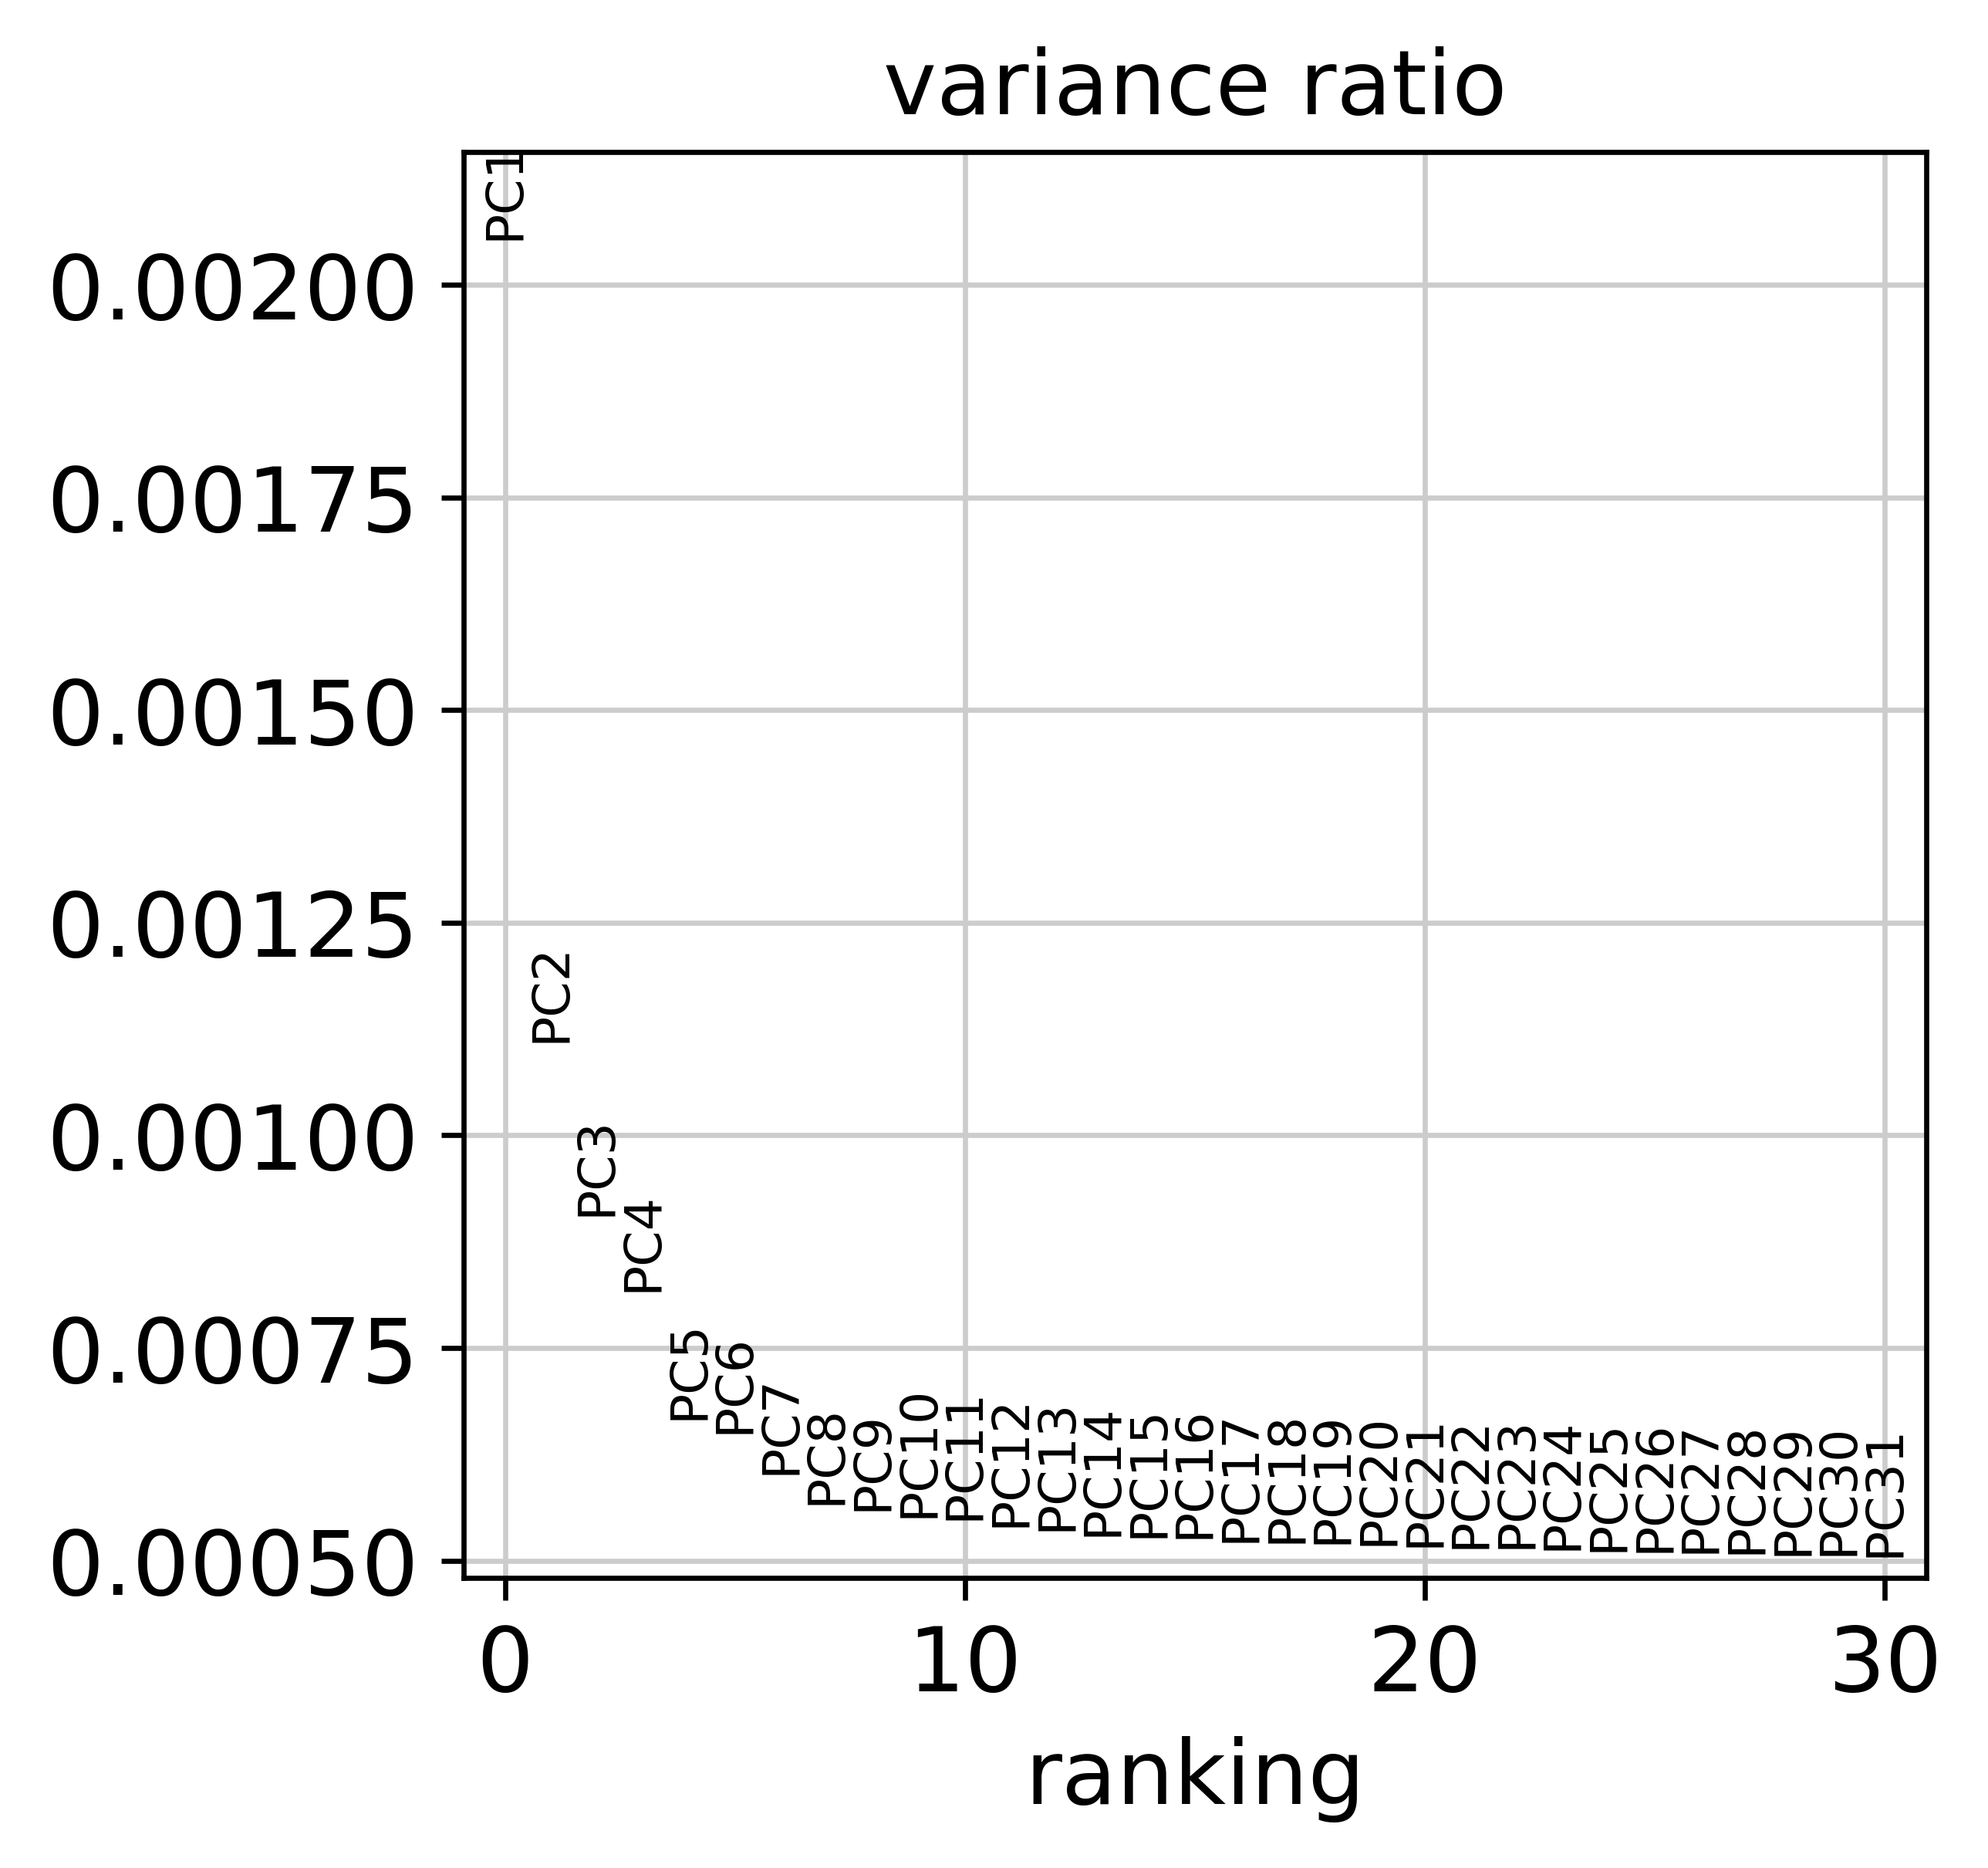

In [57]:
epi.pl.pca_overview(atac, color=['nb_features', 'cell_type'], use_raw=False)

In [59]:
epi.tl.louvain(atac)

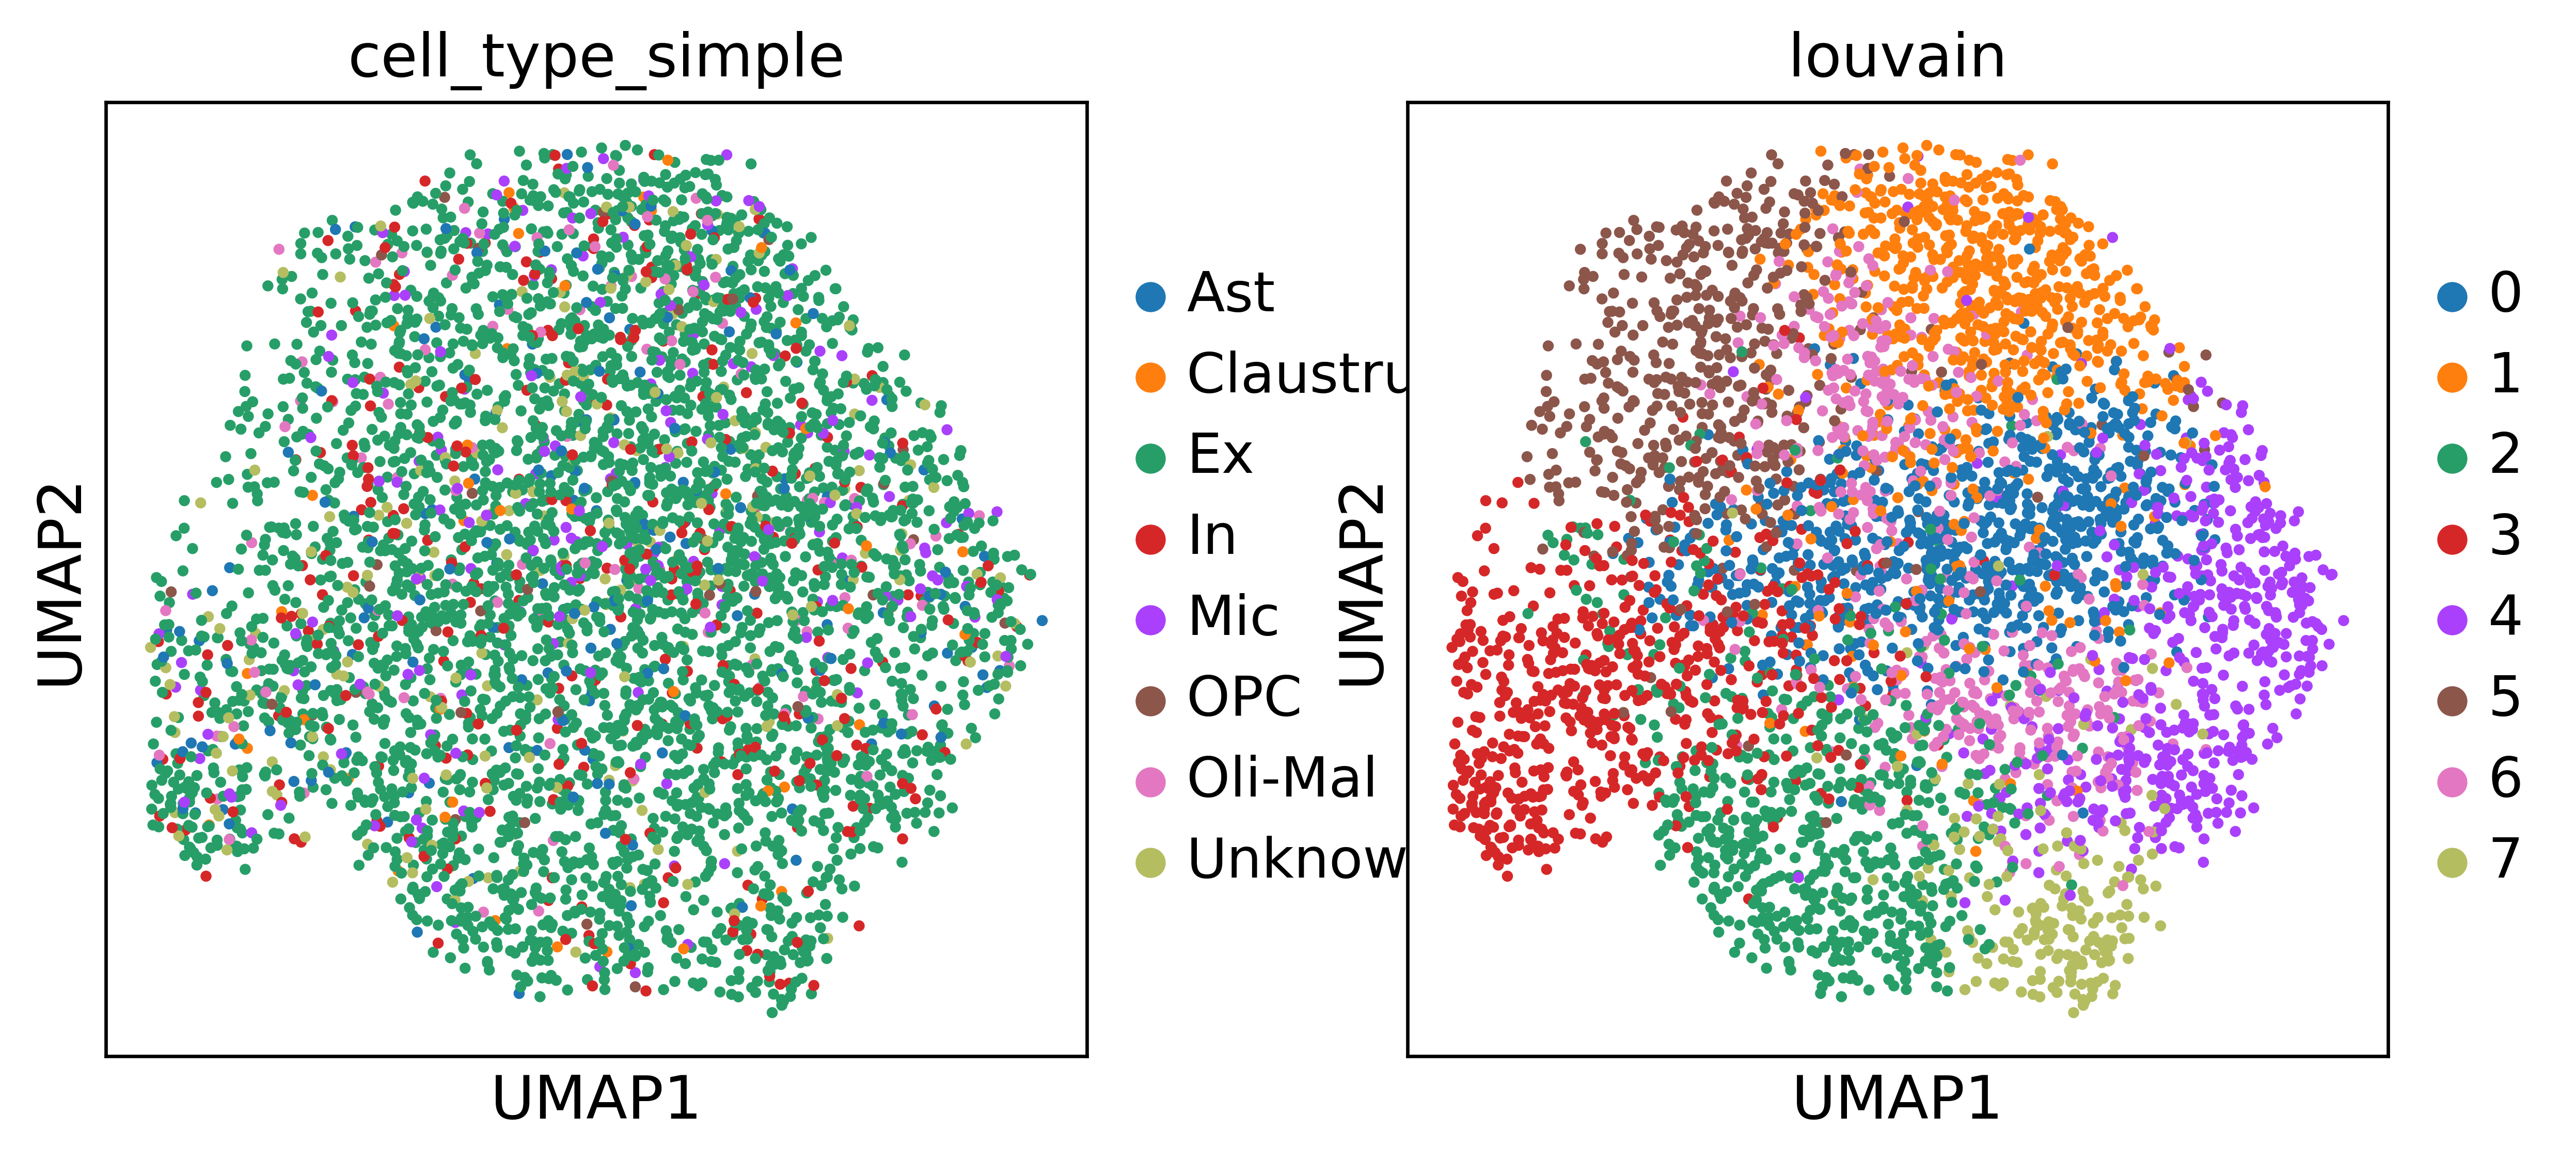

In [61]:
sc.pl.umap(atac, color=['cell_type_simple', 'louvain']) 